## Towards Resnet using CIFAR 10

In [1]:
%pwd
#!ls data/cifar10/

'/home/german/fastai/courses/dl1'

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

Here are the classes in the dataset, as well as 10 random images from each: airplane,automobile,bird,cat,deer,dog,frog, horse, ship, truck.

In [2]:
from IPython.display import Image
Image(url='http://forums.fast.ai/uploads/default/original/2X/f/f9d3a1fc94b33ffa86defed47c893ee718ef6b22.png')

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. “Automobile” includes sedans, SUVs, things of that sort. “Truck” includes only big trucks. Neither includes pickup trucks.

## Prepare Data

### A note on smaller datasets
CIFAR 10 is a small dataset. Much more challenging, smaller dataset and much smaller images. It’s a great place to start with the CIFAR-10 dataset.

Need for rigor in experiments in Deep Learning. There’s a lack of rigor in deep learning.

Is my algorithm meant to be small vs. large? People complain about MNIST (numbers/digits dataset). If you are trying to understand different parts of your algorithm, MNIST is a great place to start.

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
#You can get the data via:
#!wget http://pjreddie.com/media/files/cifar.tgz

In [5]:
from fastai.conv_learner import *
PATH = "data/CIFAR/cifar/"
OUTPATH=PATH+"cifar10/"
os.makedirs(PATH,exist_ok=True)
os.makedirs(OUTPATH,exist_ok=True)

!cp cifar.tgz data/CIFAR/

tar -xzvf cifar.tgz 

We need the stats to normalize (as we are trainning a model from scratch). 
The stats are the mean and standard deviation for the classes, for each (RGB) channel.

In [6]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

## Prepare validation set
### Create sub-folders by class;

In [7]:
for x in classes:
    os.makedirs(OUTPATH+'train/'+x,exist_ok=True)
    os.makedirs(OUTPATH+'val/'+x,exist_ok=True)
    os.makedirs(OUTPATH+'test/'+x,exist_ok=True)

### Move the files based on the file name

In [8]:
filenames = os.listdir(PATH+'train/')
counts = {x:0 for x in classes}
print(len(filenames))

50000


### Create our Validation and Train sets based on file name

In [9]:
import shutil
valset_size = len(filenames) / 10 * .2
for file_n in filenames:
    for x in classes:
        if x in file_n:
            counts[x] = counts[x] +1
            if counts[x] < valset_size:
                shutil.copyfile(PATH+'train/'+file_n, OUTPATH+'val/'+x+'/'+file_n)
            else:
                shutil.copyfile(PATH+'train/'+file_n, OUTPATH+'train/'+x+'/'+file_n)
        if 'automobile' in file_n:
            counts['car'] = counts['car'] +1
            if counts[x] < valset_size:
                shutil.copyfile(PATH+'train/'+file_n, OUTPATH+'val/car/'+file_n)
            else:
                shutil.copyfile(PATH+'train/'+file_n, OUTPATH+'train/car/'+file_n)

### Make a validation set

In [10]:
filenames = os.listdir(PATH+'test/')
for file_n in filenames:
    shutil.copy(PATH+'test/'+file_n, OUTPATH+'test/'+file_n)

## Set up our ImageClassifierData object

This will create our image generator with the following notes:

`RandomFlip()`- our basic data augmentation for flipping pictures up and down
`pad = sz//8` - this will add padding to the edges, and allow us to properly grab the corners of the image
`stats` - the image status calculated above
`OUTPATH`, the location of our CIFAR-10 set


Random flipping and padding over the edge. The `pad` parameter will add 4 pixels on each size.
Then we create the ImageClassigier

In [11]:
def get_data(sz,bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)  # [RandomFlipXY()], pad=sz//8)
    return ImageClassifierData.from_paths(OUTPATH, val_name='val', tfms=tfms, bs=bs)

In [12]:
bs=256 # because they are small, we can use a larger batch size.

### Look at data

In [13]:
data = get_data(32,4)

In [14]:
x,y=next(iter(data.trn_dl))

In [15]:
type(x)

torch.cuda.FloatTensor

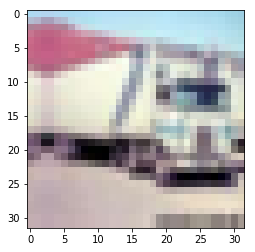

In [16]:
plt.imshow(data.trn_ds.denorm(x)[0]);

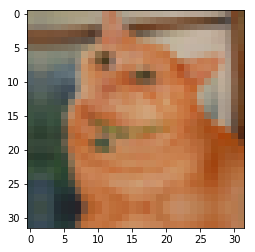

In [17]:
plt.imshow(data.trn_ds.denorm(x)[1]);

## Fully connected model
This section will make layers number of fully connected linear layers.

 - self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
- x = x.view(x.size(0), -1) - flatten the data as it comes in
- l_x = l(x) - call the linear layer
- x = F.relu(l_x) - apply the ReLU to the layer
- F.log_softmax(l_x, dim=-1) so that we can make probabilities for 10 classes

In [18]:
data = get_data(32,bs)

In [19]:
lr=1e-2

From [this notebook](https://github.com/KeremTurgutlu/deeplearning/blob/master/Exploring%20Optimizers.ipynb) by our student Kerem Turgutlu:

In [20]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)   # flatten
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

Make a learner for our general model

In [21]:
learn = ConvLearner.from_model_data(SimpleNet([32*32*3, 40,10]), data)

So what is our design?
- 3072 features = 32 x32 x 3 channels
- 40 features going out and going in
- 10 because we have 10 classes we are trying to classify
- 122800 total parameters

In [22]:
learn, [o.numel() for o in learn.model.parameters()]

(SimpleNet(
   (layers): ModuleList(
     (0): Linear(in_features=3072, out_features=40)
     (1): Linear(in_features=40, out_features=10)
   )
 ), [122880, 40, 400, 10])

In [23]:
learn.summary()

OrderedDict([('Linear-1',
              OrderedDict([('input_shape', [-1, 3072]),
                           ('output_shape', [-1, 40]),
                           ('trainable', True),
                           ('nb_params', 122920)])),
             ('Linear-2',
              OrderedDict([('input_shape', [-1, 40]),
                           ('output_shape', [-1, 10]),
                           ('trainable', True),
                           ('nb_params', 410)]))])

In [24]:
learn.lr_find()

A Jupyter Widget

 76%|███████▌  | 121/160 [00:17<00:05,  6.82it/s, loss=20.3]

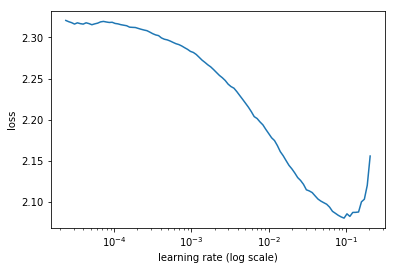

In [25]:
learn.sched.plot()

In [26]:
%time learn.fit(lr, 2)

A Jupyter Widget

 29%|██▉       | 47/160 [00:09<00:22,  5.11it/s, loss=1.98] 


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/german/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/german/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/german/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                   
    0      1.791907   1.697868   0.389216  
    1      1.709123   1.614315   0.424998                   

CPU times: user 1min 16s, sys: 26.9 s, total: 1min 43s
Wall time: 55 s


[array([ 1.61432]), 0.42499750824662796]

In [27]:
%time learn.fit(lr, 2, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                   
    0      1.634124   1.558345   0.451709  
    1      1.614254   1.532265   0.460281                   

CPU times: user 1min 17s, sys: 27.5 s, total: 1min 44s
Wall time: 55.5 s


[array([ 1.53227]), 0.46028107238958876]

so with 122K parameters we only got .4786 accuracy...

## CNN

On our way to ResNet: first convolutional model: (0.56 accuracy)
fully connected layer - is really doing a dot product. Previously 122800 is a weight for every pixel, which isn’t that useful.

But we want to use convolutions.
Now lets take the same code and replace nn.Linear with `nn.conv2d`.
Every time we want to make the next layer smaller.
Previously, in the "old days",  we did this with maxpooling...
These days we don't use maxpooling, but rather use a stride=2 convolution, 
i.e., move 2 the right, at the end of the row 2-down. 
This also halves the resolution.
The first parameters are number of features in and out.

Instead of telling it what to create, we tell it what we expect.
Then the penultimate layer (adaptiveMaxPool) is made to be 1x1, the single largest cell 
and use it as an activation, so we get a 1x1xnumber of features tensor.
So the next step with .view it returns a matrix of minibatch x number_of_features.  

In [28]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, stride=2)
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1) # penultime layer is made into a 1by 1 maxpool
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

Notice below the last parameter is c=10, which indicates how many classes we want as output (for the 10 CIFAR categories)

In [29]:
learn = ConvLearner.from_model_data(ConvNet([3, 20, 40, 80], 10), data)

See how the output shape keeps changing below....
Note the change of the sizes
32 -> 15 -> 7 -> 3 -> 1

`AdaptiveMaxPool2d` - you don’t tell it how bit of a pool that you need, but instead telling it the output size and the pool will calculate what size will be needed. Normal practice is to make a 1x1 max pool as the last layer to ensure that we have the right size.

- for l in self.layers: x = F.relu(l(x))- does all the conv layers
- x = self.pool(x) - adaptive max pool
- x = x.view(x.size(0), -1) - gets rid of training axis 1,1

at the end we need to get 10 classes....
This is called a *Fully Convolutional Network*, where every layer is Convolutional except the last.

Now we have about 1/4 the number of parameters as in the SimpleNet....but much better accuracy.

In [30]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 15, 15]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 20, 15, 15]),
                           ('output_shape', [-1, 40, 7, 7]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 40, 7, 7]),
                           ('output_shape', [-1, 80, 3, 3]),
                           ('trainable', True),
                           ('nb_params', 28880)])),
             ('AdaptiveMaxPool2d-4',
              OrderedDict([('input_shape', [-1, 80, 3, 3]),
                           ('output_shape', [-1, 80, 1, 1]),
                           ('nb_params', 0)])),
             ('Linear-5',
              OrderedDict

lr_find below override the last one so it will try more... (?)

In [31]:
learn.lr_find(end_lr=100)

A Jupyter Widget

 74%|███████▍  | 119/160 [00:18<00:06,  6.33it/s, loss=3.27e+04]

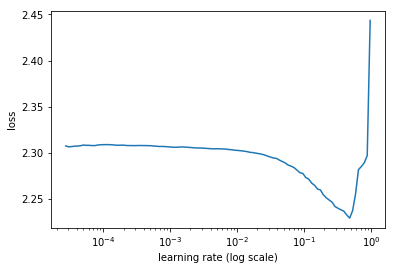

In [32]:
learn.sched.plot()

In [33]:
%time learn.fit(1e-1, 2)

A Jupyter Widget

 23%|██▎       | 37/160 [00:07<00:25,  4.87it/s, loss=2.15]     


Exception in thread Thread-10:
Traceback (most recent call last):
  File "/home/german/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/german/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/german/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                   
    0      1.76259    1.611702   0.40616   
    1      1.559925   1.522092   0.448121                   

CPU times: user 1min 22s, sys: 28 s, total: 1min 50s
Wall time: 58.7 s


[array([ 1.52209]), 0.44812120016462648]

In [34]:
%time learn.fit(1e-1, 4, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                   
    0      1.440765   1.359639   0.504834  
    1      1.350055   1.285724   0.538523                   
    2      1.304012   1.23475    0.559753                   
    3      1.259733   1.18448    0.582278                   

CPU times: user 2min 38s, sys: 54.9 s, total: 3min 33s
Wall time: 1min 53s


[array([ 1.18448]), 0.58227848094730872]

## Refactored
Want to have less stuff inside my forward...
And add padding.
grouping things to make life easier
We will make a custom conv. layer to bundle the conv2d along with a relu. We are also adding padding to take in account the corners of the image.

In [35]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x): return F.relu(self.conv(x))

In [36]:
class ConvNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([ConvLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [37]:
learn = ConvLearner.from_model_data(ConvNet2([3, 20, 40, 80], 10), data)

In [38]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('ConvLayer-2',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('ConvLayer-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 40, 8, 8]),
                 

In [39]:
%time learn.fit(1e-1, 2)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                   
    0      1.786108   1.753718   0.364198  
    1      1.567001   1.514862   0.459185                   

CPU times: user 1min 15s, sys: 26.5 s, total: 1min 41s
Wall time: 54 s


[array([ 1.51486]), 0.45918469044998944]

In [40]:
%time learn.fit(1e-1, 2, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                   
    0      1.387131   1.322312   0.523871  
    1      1.329855   1.265149   0.547394                   

CPU times: user 1min 17s, sys: 26.8 s, total: 1min 44s
Wall time: 55.1 s


[array([ 1.26515]), 0.5473936011935473]

## BatchNorm
Batch Normalization (0.68 accuracy)
When we tried to add more layers we had problems training it. 
If we have smaller learning rates, it takes too long, and if we made larger learning rates, it would become unstable. The basic idea is that we have some vector of activations, that as we do matrix multiplication, that a matrix can easily get too large and grow too large.

This additional code will normalize the matrix first by channel and later by filters.

Basic idea is to normalize every layer, not just the inputs.
So we need to calculate the mean and std (per channel or per filter) and remove it accordingly...
But then SGD will try to undo it on the next minibatch... so it is like doing nothing (?)
So what we do is create a new multiplier (self.m) and a new added value (self.a) for each channel.
(m initialized to 1s, and a to 0s).
By telling Pytorch that these are `nn.Parameter` they are then learned as if they were weights.
And use them to shift and scale...  
Alllows to increase the learning rate
So now SGD has a way to do things...
This seems weird... so we understand it intuitively, but 
hat the vector of activations is coming to a convolution layer, because gradiants will explode in a deep network... 

This additional code will normalize the matrix first by channel and later by filters.

   if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
Turns out there’s a conflict with SGD, and it won’t help. So we make a new multiplier and new addition for each channel.

    self.a = nn.Parameter(torch.zeros(nf,1,1))
    self.m = nn.Parameter(torch.ones(nf,1,1))
Then we can do the multiplication. This seems weird because we are multiplying by 1 and adding zero. But this will let SGD shift the weights around in the m and a variables. We are normalizing the data, and SGD is moving and shifting it using far fewer variables than previously.

 return (x-self.means) / self.stds *self.m + self.a
 
 This increases resiliency and let’s us increase the learning rate and more learning rates.

In [41]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None] 
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

**Two changes**
Added the BnLayer.
Added a ‘rich’ Conv2d layer up front. Instead of a 3 x 3, we are doing a 5x5 / 7x7 convolution with a large number of filters.

In [42]:
class ConvBnNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [43]:
learn = ConvLearner.from_model_data(ConvBnNet([10, 20, 40, 80, 160], 10), data)

In [44]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 760)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7200)])),
             ('BnLayer-5',
              OrderedDict([

In [45]:
%time learn.fit(3e-2, 2)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                   
    0      1.532308   1.35874    0.510615  
    1      1.321974   1.138207   0.590651                   

CPU times: user 1min 23s, sys: 28.3 s, total: 1min 52s
Wall time: 58.8 s


[array([ 1.13821]), 0.59065085212837176]

In [46]:
%time VLA = learn.fit(1e-1, 4, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                   
    0      1.208039   1.056631   0.627728  
    1      1.090417   0.951413   0.664507                   
    2      1.024119   0.899084   0.681451                   
    3      0.966237   0.847337   0.704774                    

CPU times: user 2min 38s, sys: 52.9 s, total: 3min 31s
Wall time: 1min 50s


So we now reached {{VLA[0]}} for Validation loss and {{VLA[1]}} for accuracy

## Deep BatchNorm
Let’s make it an even deeper model. But we have to be mindful of the image size. 
If we keep reducing the image size, it will eventually be too small.

So each of the stride 2 layers (layers) we also add a stride=1 layer (layers2 below) which doesn’t change the size. 
Now the network is twice as deep, but have the same image size at the end.
Now the this is twice as deep, and should be able to help us out... but... it does not... :(

In [47]:
class ConvBnNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([BnLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2 in zip(self.layers, self.layers2):
            x = l(x)
            x = l2(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [48]:
learn = ConvLearner.from_model_data(ConvBnNet2([10, 20, 40, 80, 160], 10), data)

In [49]:
%time learn.fit(1e-2, 2)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                   
    0      1.542061   1.387011   0.492874  
    1      1.34302    1.23217    0.552377                   

CPU times: user 1min 22s, sys: 26.7 s, total: 1min 49s
Wall time: 57.3 s


[array([ 1.23217]), 0.55237715552386191]

In [50]:
%time learn.fit(1e-2, 2, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                   
    0      1.160674   1.071229   0.614074  
    1      1.095488   1.007243   0.644573                   

CPU times: user 1min 22s, sys: 26.7 s, total: 1min 49s
Wall time: 57.3 s


[array([ 1.00724]), 0.64457290933957478]

## Residual Network (Resnet)
ResNet block: we are adding the original signal along with the convolution of the input:

- y = x + f(x)
- f(x) = y - x
Where y is the prediction of the next layer, and x is the prediction of the previous layer. The difference is actually the residual (residual = y-x). This is basically saying: find some weights to predict the error. We are continuously trying to predict the residual error, layer by layer.

This is similar to the idea of **boosting** from machine learning.
It helps a lot!


In [51]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

Note that we have added 2 ResNet layers and also note we have a function of a function of a function:

x = l3(l2(l(x)))

In [52]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [53]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 10), data)

In [54]:
wd=1e-5

In [55]:
%time learn.fit(1e-2, 2, wds=wd)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                   
    0      1.631071   1.434121   0.484102  
    1      1.398441   1.292878   0.528755                   

CPU times: user 1min 27s, sys: 27.8 s, total: 1min 55s
Wall time: 1min 2s


[array([ 1.29288]), 0.52875510813718685]

In [56]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                   
    0      1.208201   1.106239   0.604106  
    1      1.160225   1.047153   0.626433                   
    2      1.015941   0.9577     0.660221                   
    3      1.060667   0.984687   0.654839                   
    4      0.942284   0.865005   0.694807                    
    5      0.842741   0.817229   0.713147                    
    6      0.793304   0.785172   0.725207                    

CPU times: user 5min, sys: 1min 35s, total: 6min 36s
Wall time: 3min 34s


[array([ 0.78517]), 0.72520681740124804]

In [57]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                    
    0      0.889288   0.858912   0.697997  
    1      0.812393   0.784561   0.723213                    
    2      0.72797    0.720518   0.746736                    
    3      0.680144   0.702491   0.752716                    
    4      0.780572   0.771017   0.732383                    
    5      0.71681    0.722989   0.747633                    
    6      0.63339    0.674483   0.763979                    
    7      0.58519    0.644218   0.773547                    
    8      0.68914    0.72141    0.747334                    
    9      0.642703   0.673601   0.768065                    
    10     0.559442   0.61624    0.786106                    
    11     0.520905   0.611422   0.7879                      
    12     0.640278   0.68063    0.768464                    
    13     0.568615   0.63207    0.782019                    
    14     0.505908   0.585964   0.797767                    
    15     0.471782   0.57

[array([ 0.53077]), 0.82288448125952729]

## Resnet 2
Most of these ResNet blocks have 2 convolutions. We call these skip connections.



In [58]:
class Resnet2(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(self.out(x), dim=-1)

In [59]:
learn = ConvLearner.from_model_data(Resnet2([16, 32, 64, 128, 256], 10, 0.2), data)

In [60]:
wd=1e-6

In [61]:
%time learn.fit(1e-2, 2, wds=wd)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                   
    0      1.74444    1.564964   0.462673  
    1      1.53967    1.313877   0.533539                   

CPU times: user 1min 32s, sys: 29.4 s, total: 2min 1s
Wall time: 1min 6s


[array([ 1.31388]), 0.53353932021943395]

In [ ]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                   
    0      1.285711   1.145255   0.585269  
    1      1.253897   1.106832   0.608691                   
    2      1.104587   1.024738   0.636998                   
    3      1.141567   1.016684   0.639191                   
    4      1.019201   0.930835   0.666202                   
    5      0.903506   0.827692   0.702482                    
    6      0.855082   0.812358   0.711253                    

CPU times: user 5min 16s, sys: 1min 41s, total: 6min 57s
Wall time: 3min 50s


[array([ 0.81236]), 0.71125286568034551]

In [63]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                    
    0      0.952971   0.856824   0.694109  
    1      0.866283   0.789806   0.72411                     
    2      0.777048   0.729335   0.744543                    
    3      0.73113    0.718995   0.747134                    
    4      0.832334   0.790203   0.726602                    
    5      0.756757   0.730112   0.742051                    
    6      0.676185   0.663298   0.76966                     
    7      0.629203   0.651066   0.774843                    
    8      0.755372   0.700142   0.75461                     
    9      0.679226   0.652529   0.773547                    
    10     0.601374   0.628108   0.784312                    
    11     0.56066    0.598213   0.792086                    
    12     0.663517   0.65622    0.773747                    
    13     0.624141   0.615881   0.788299                    
    14     0.539068   0.590312   0.797468                    
    15     0.509856   0.57

[array([ 0.50988]), 0.82956244403006818]

In [64]:
learn.save('tmp3')

In [65]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)

In [66]:
metrics.log_loss(y,preds), accuracy_np(preds,y)

(0.45800556638443823, 0.84381540914980568)

### End